In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import tqdm
import time
import yaml
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import torch.fft
import torchvision
import torchvision.models as models

#torch.multiprocessing.set_start_method('spawn')

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [3]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [4]:
class InferencePropagator:
    
    def __init__(self, 
                 data_path,
                 n_bins = 1000, 
                 tile_size = 512, 
                 step_size = 128, 
                 marker_size = 10, 
                 device = "cuda"):
        
        self.h_ds = xr.open_dataset(data_path)
        self.n_bins = n_bins
        self.z_bins = np.linspace(self.h_ds.attrs['zMin'],self.h_ds.attrs['zMax'],n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        self.marker_size = marker_size # UNET gaussian marker width (standard deviation) in um
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx']) # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda'] # wavelength
        self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
        self.zMax = self.h_ds.attrs['zMax'] 
        self.image_norm = 255.0

        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy
        
        self.tile_x_bins = np.arange(-self.Nx//2,self.Nx//2,self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,self.Ny//2,self.step_size)*self.dy*1e6
        
        self.fx = None
        self.fy = None

    
    def compute_f(self):
        self.fx = torch.fft.fftfreq(self.Nx,self.dx,device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(self.Ny,self.dy,device=self.device).unsqueeze(0).unsqueeze(1)
        
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        if self.fx is None:
            self.compute_f()
        
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam*torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout
    
    def get_sub_images(self, image_tnsr, z_sub_set, z_counter):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        # build the torch tensor for reconstruction
        z_plane = torch.tensor(z_sub_set*1e-6, device=self.device).unsqueeze(-1).unsqueeze(-1)

        # reconstruct the selected planes
        E_out = self.torch_holo_set(image_tnsr, z_plane).detach().cpu().numpy()

#         Esub = []
#         z_pos = []
#         image_corner_coords = []
#         image_index_lst = []

#         for z_idx in range(E_out.shape[0]):
#             for row_idx in range(0,E_out.shape[1]//self.step_size):
#                 for col_idx in range(0,E_out.shape[2]//self.step_size):
#                     Esub.append(E_out[z_idx,row_idx:row_idx+self.tile_size,col_idx:col_idx+self.tile_size])
#                     z_pos.append(z_sub_set[z_idx]*1e-6)
#                     image_corner_coords.append([self.x_arr[row_idx*self.step_size], self.y_arr[col_idx*self.step_size]])
#                     image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
#         return Esub, image_index_lst, image_corner_coords, z_pos
    
        Esub = []
        z_pos = []
        image_corner_coords = []
        image_index_lst = []

        for z_idx in range(E_out.shape[0]):
            for row_idx in range(0,E_out.shape[1]//self.step_size):
                if row_idx*self.step_size+self.tile_size > E_out.shape[1]:
                    row_slice = slice(-self.tile_size,None)
                    row_break = True
                else:
                    row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                    row_break = False

                for col_idx in range(0,E_out.shape[2]//self.step_size):
                    if col_idx*self.step_size+self.tile_size > E_out.shape[2]:
                        col_slice = slice(-self.tile_size,None)
                        col_break = True
                    else:
                        col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                        col_break = False

                    Esub.append(E_out[z_idx,row_slice,col_slice])
                    if Esub[-1].shape != (self.tile_size,self.tile_size):
                        print(f"Incorrect image size in tile: {Esub[-1].shape} ")

                    z_pos.append(z_sub_set[z_idx]*1e-6)
                    image_corner_coords.append([self.x_arr[row_slice][0], self.y_arr[col_slice][0]])
                    image_index_lst.append([row_idx,col_idx,z_idx+z_counter])

                    if col_break:
                        break

                if row_break:
                    break

        return Esub, image_index_lst, image_corner_coords, z_pos
    
    def get_sub_images_labeled(self,image_tnsr,z_sub_set,z_counter, xp, yp, zp, dp, infocus_mask, z_part_bin_idx):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        # build the torch tensor for reconstruction
        z_plane = torch.tensor(z_sub_set*1e-6,device=self.device).unsqueeze(-1).unsqueeze(-1)

        # reconstruct the selected planes
        E_out = self.torch_holo_set(image_tnsr,z_plane).detach().cpu().numpy()

        Esub = []
        z_pos = []
        image_corner_coords = []
        image_index_lst = []
        image_pixel_coords = []
        unet_sub = []
        in_focus_sub = []

        for z_idx in range(E_out.shape[0]):
            unet_mask = np.zeros(E_out.shape[1:])  # initialize the UNET mask
            part_in_plane_idx = np.where(z_part_bin_idx==z_idx+z_counter)[0]  # locate all particles in this plane

            # build the UNET mask for this z plane
            for part_idx in part_in_plane_idx:
                unet_mask += np.exp(
                    -(self.y_arr[None,:]*1e6-yp[part_idx])**2/(2*self.marker_size**2) - (self.x_arr[:,None]*1e6-xp[part_idx])**2/(2*self.marker_size**2) 
                )

            for row_idx in range(0,E_out.shape[1]//self.step_size):
                if row_idx*self.step_size+self.tile_size > E_out.shape[1]:
                    image_pixel_x = E_out.shape[1]-self.tile_size
                    row_slice = slice(-self.tile_size,None)
                    row_break = True
                else:
                    image_pixel_x = row_idx*self.step_size
                    row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                    row_break = False

                for col_idx in range(0,E_out.shape[2]//step_size):
                    if col_idx*self.step_size+self.tile_size > E_out.shape[2]:
                        image_pixel_y = E_out.shape[2]-self.tile_size
                        col_slice = slice(-self.tile_size,None)
                        col_break = True
                    else:
                        image_pixel_y = col_idx*self.step_size
                        col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                        col_break = False

                    Esub.append(E_out[z_idx,row_slice,col_slice])
                    unet_sub.append(unet_mask[row_slice,col_slice])
                    if Esub[-1].shape != (self.tile_size,self.tile_size):
                        print(f"Incorrect image size in tile: {Esub[-1].shape} ")

                    z_pos.append(z_sub_set[z_idx]*1e-6)
                    image_corner_coords.append([self.x_arr[row_slice][0], self.y_arr[col_slice][0]])
                    image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
                    image_pixel_coords.append([image_pixel_x,image_pixel_y])
                    in_focus_sub.append(infocus_mask[row_idx,col_idx,z_idx+z_counter])

                    if col_break:
                        break

                if row_break:
                    break

        return Esub, image_index_lst, image_corner_coords, z_pos, image_pixel_coords, unet_sub, in_focus_sub
    
    
    def get_next_z_planes(self, h_idx, z_planes_lst):
        """
        Generator that returns reconstructed z patches
        image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """
        
        input_image = self.h_ds['image'].isel(hologram_number=h_idx)

        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image.values, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            sub_image, image_index_lst, image_coords, image_z = self.get_sub_images(image_tnsr,z_sub_set,z_counter)
            z_counter+=z_sub_set.size
            yield sub_image, image_index_lst, image_coords, image_z
            
    def get_next_z_planes_labeled(self, h_idx, z_planes_lst):
        """
        Generator that returns reconstructed z patches
        input_image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """

        # locate particle information corresponding to this hologram
        particle_idx = np.where(self.h_ds['hid'].values==h_idx+1)

        x_part = self.h_ds['x'].values[particle_idx]
        y_part = self.h_ds['y'].values[particle_idx]
        z_part = self.h_ds['z'].values[particle_idx]
        d_part = self.h_ds['d'].values[particle_idx]  # not used but here it is

        # create a 3D histogram 
        in_data = np.stack((x_part, y_part, z_part)).T
        h_part = np.histogramdd(in_data,bins=[self.tile_x_bins,self.tile_y_bins,self.z_bins])[0]
        z_part_bin_idx = np.digitize(z_part,self.z_bins)-1 # specify the z bin locations of the particles

        # smoothing kernel accounts for overlapping subimages when the 
        # subimage is larger than the stride
        if self.step_size < self.tile_size:
            overlap_kernel = np.ones((
                self.tile_size//self.step_size,self.tile_size//self.step_size
            ))
            for z_idx in range(h_part.shape[-1]):
                b = self.tile_size//self.step_size
                h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[b-1:h_part.shape[0]+b-1,b-1:h_part.shape[1]+b-1]

        input_image = self.h_ds['image'].isel(hologram_number=h_idx).values


        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            sub_image, image_index_lst, image_coords, image_z, image_pixels, unet_labels, in_focus_labels = \
                    self.get_sub_images_labeled(image_tnsr, z_sub_set, z_counter, x_part, y_part, z_part, d_part, h_part, z_part_bin_idx)
            z_counter+=z_sub_set.size
            yield sub_image, image_index_lst, image_coords, image_z, image_pixels, unet_labels, in_focus_labels
            
    def create_z_plane_lst(self, planes_per_call=1):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in np.arange(0, self.z_centers.size, planes_per_call):
            z_lst.append(self.z_centers[z_idx:(z_idx+planes_per_call)])
        return z_lst

In [5]:
synthetic_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

n_bins = 1000  # number of bins in histogram
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

In [6]:
prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    device = device
)

In [14]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

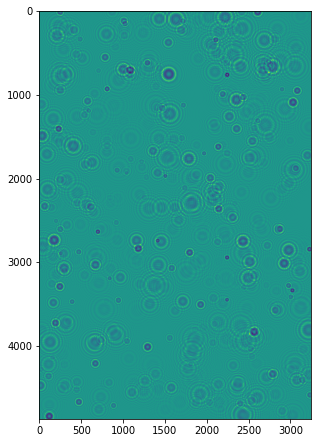

In [15]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (5, 5 * ratio))
plt.imshow(test_image.values)

In [7]:
#z_list = prop.create_z_plane_lst(planes_per_call=1)

In [8]:
#chunked_z_list = np.array_split(z_list, 8)

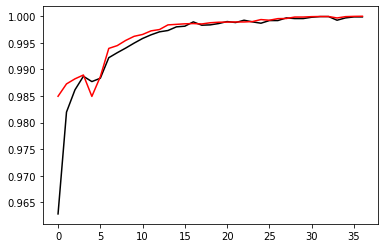

In [12]:
# Load a model

model_loc = "resnet50" #"z10000"
f = pd.read_csv(f"{model_loc}/training_log_resnet.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')


fcl_layers = []
dropout = 0.2
output_size = 2
resnet_model = 50
pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best_resnet.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
#z_list_sample = random.sample(z_list, 50)

z_list = prop.create_z_plane_lst(planes_per_call=1)

inference_generator = prop.get_next_z_planes_labeled(h_idx, z_list)

Plane 0 at z: 0.014072 balanced_acc: 0.9649 balanced_holo_acc: 0.9649:   0%|          | 1/1000 [00:08<2:23:21,  8.61s/it]

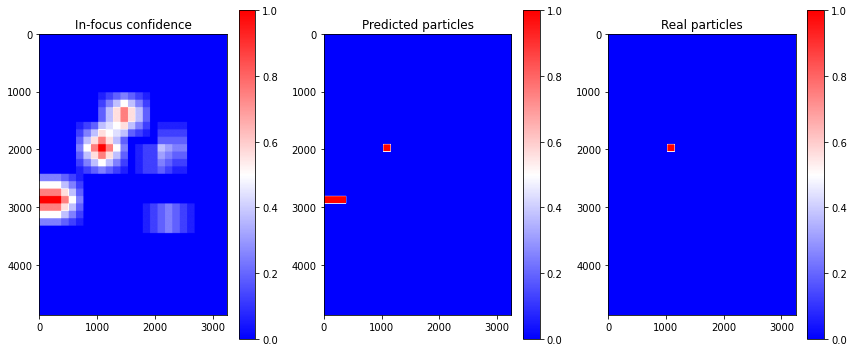

Plane 1 at z: 0.014216 balanced_acc: 0.9509 balanced_holo_acc: 0.9579:   0%|          | 3/1000 [00:19<1:41:09,  6.09s/it]

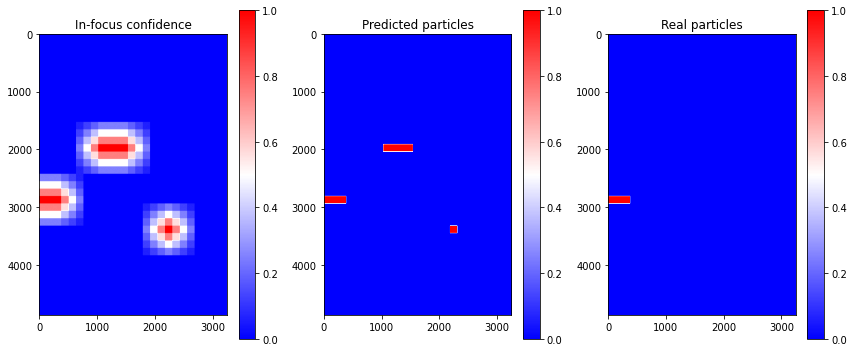

Plane 2 at z: 0.01436 balanced_acc: 0.8571 balanced_holo_acc: 0.9243:   0%|          | 4/1000 [00:30<2:12:09,  7.96s/it] 

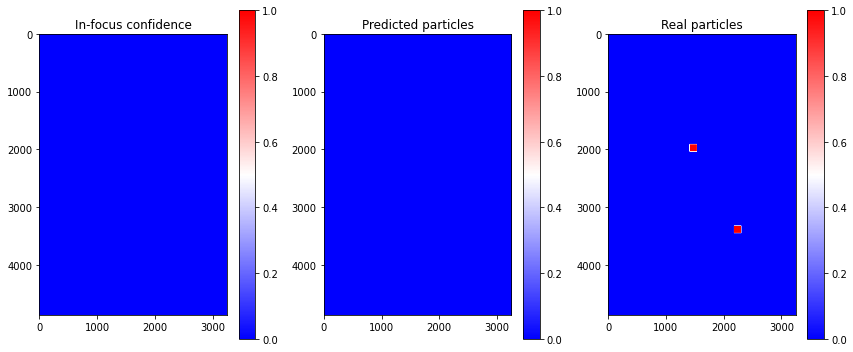

Plane 3 at z: 0.014504 balanced_acc: 0.9821 balanced_holo_acc: 0.9388:   1%|          | 6/1000 [00:40<1:44:38,  6.32s/it]

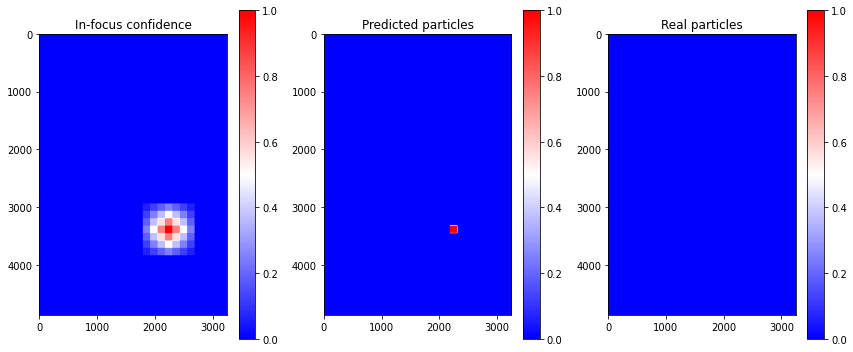

Plane 4 at z: 0.014648 balanced_acc: 0.9777 balanced_holo_acc: 0.9466:   1%|          | 7/1000 [00:51<2:07:34,  7.71s/it]

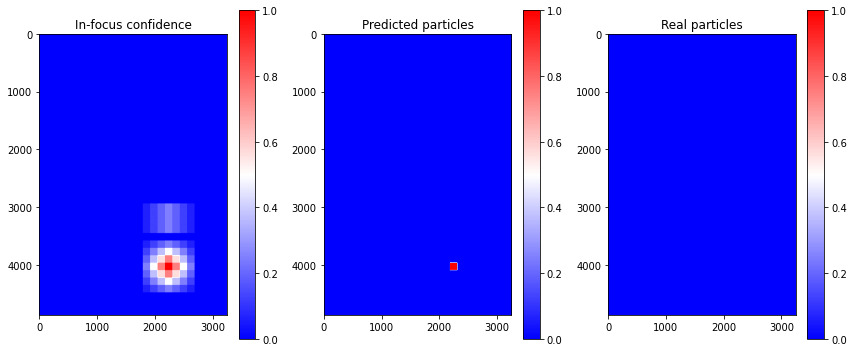

Plane 5 at z: 0.014792 balanced_acc: 0.9732 balanced_holo_acc: 0.9510:   1%|          | 8/1000 [01:02<2:24:13,  8.72s/it]

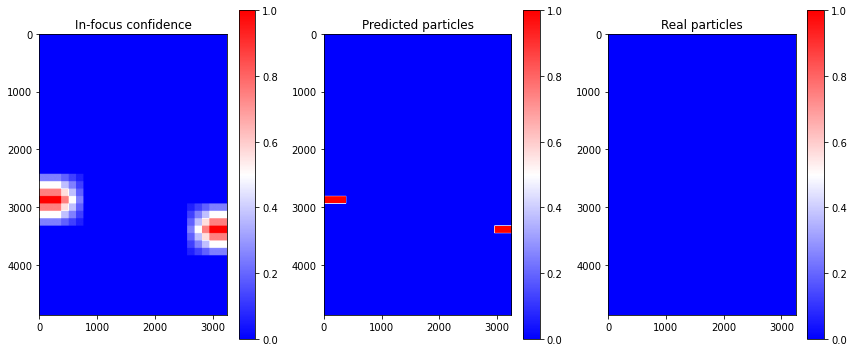

Plane 6 at z: 0.014936 balanced_acc: 1.0000 balanced_holo_acc: 0.9580:   1%|          | 10/1000 [01:12<1:52:38,  6.83s/it]

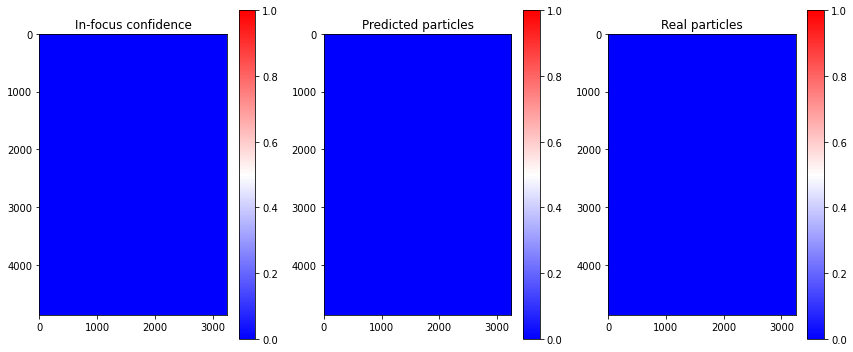

Plane 7 at z: 0.01508 balanced_acc: 0.9810 balanced_holo_acc: 0.9609:   1%|          | 11/1000 [01:23<2:11:07,  7.96s/it] 

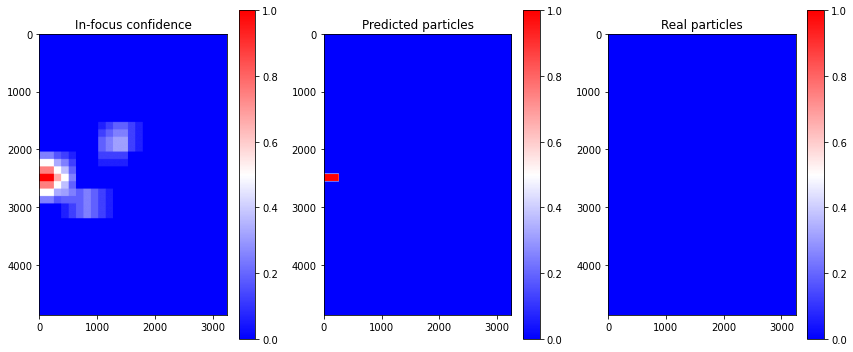

Plane 8 at z: 0.015224 balanced_acc: 1.0000 balanced_holo_acc: 0.9652:   1%|          | 12/1000 [01:34<2:24:52,  8.80s/it]

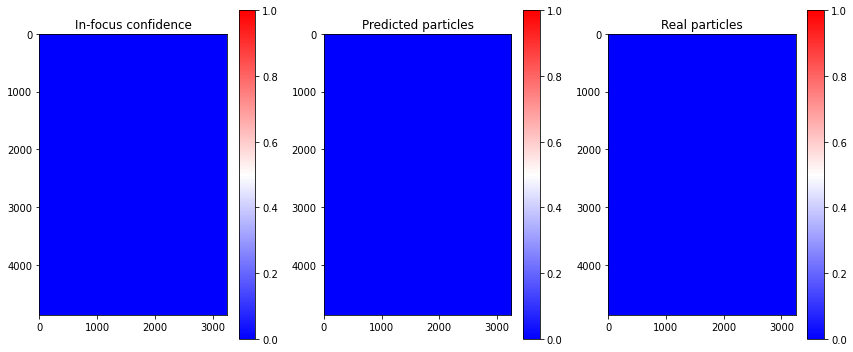

Plane 9 at z: 0.015368 balanced_acc: 0.9955 balanced_holo_acc: 0.9683:   1%|▏         | 13/1000 [01:44<2:32:07,  9.25s/it]

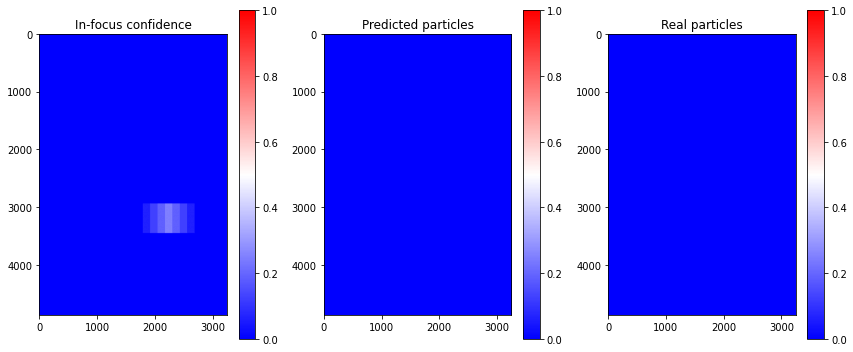

Plane 10 at z: 0.015512 balanced_acc: 0.9978 balanced_holo_acc: 0.9709:   2%|▏         | 15/1000 [01:55<1:57:23,  7.15s/it]

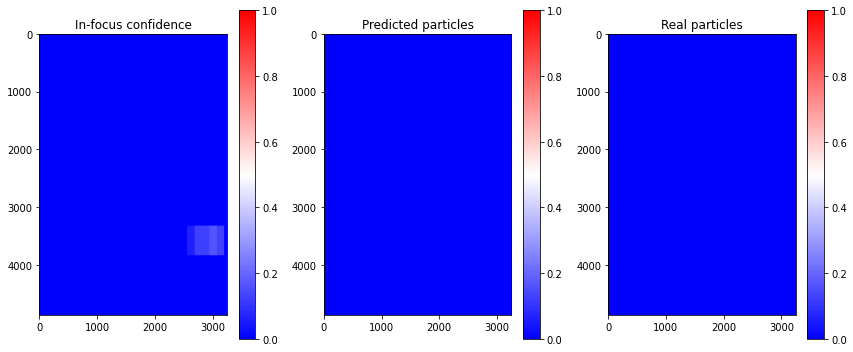

Plane 11 at z: 0.015656 balanced_acc: 0.9821 balanced_holo_acc: 0.9719:   2%|▏         | 16/1000 [02:05<2:15:34,  8.27s/it]

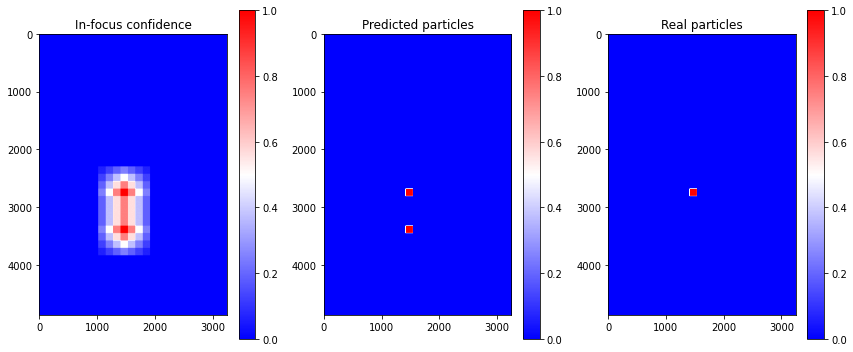

Plane 12 at z: 0.015799999999999998 balanced_acc: 0.9777 balanced_holo_acc: 0.9723:   2%|▏         | 17/1000 [02:16<2:27:17,  8.99s/it]

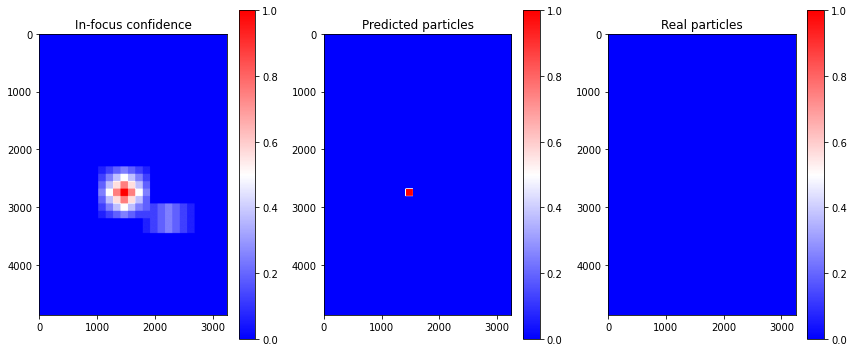

Plane 13 at z: 0.015944 balanced_acc: 1.0000 balanced_holo_acc: 0.9743:   2%|▏         | 18/1000 [02:27<2:34:43,  9.45s/it]            

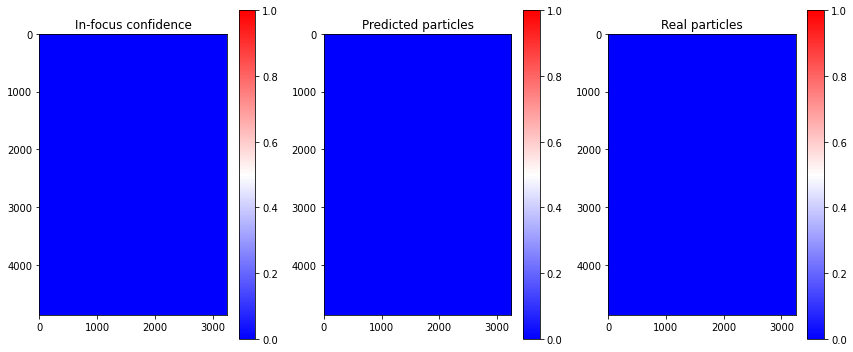

Plane 14 at z: 0.016087999999999998 balanced_acc: 0.8547 balanced_holo_acc: 0.9663:   2%|▏         | 19/1000 [02:37<2:40:58,  9.85s/it]

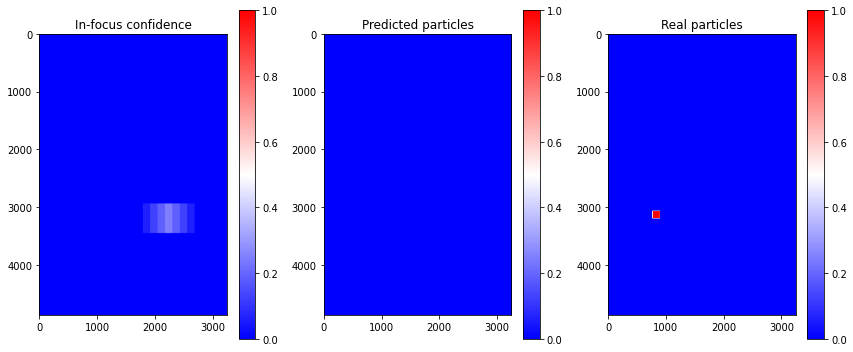

Plane 15 at z: 0.016232 balanced_acc: 1.0000 balanced_holo_acc: 0.9684:   2%|▏         | 21/1000 [02:48<2:02:11,  7.49s/it]            

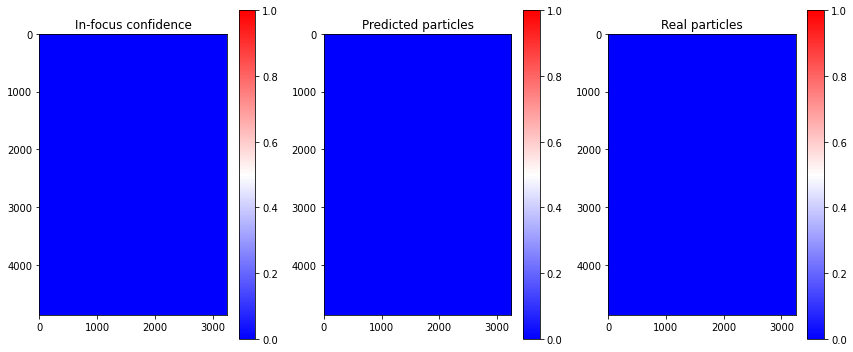

Plane 16 at z: 0.016375999999999998 balanced_acc: 0.9643 balanced_holo_acc: 0.9682:   2%|▏         | 22/1000 [02:58<2:16:07,  8.35s/it]

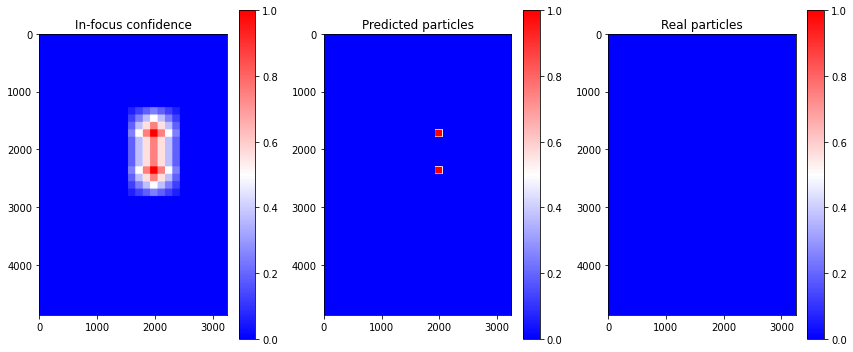

Plane 17 at z: 0.01652 balanced_acc: 0.8571 balanced_holo_acc: 0.9620:   2%|▏         | 23/1000 [03:09<2:28:16,  9.11s/it]             

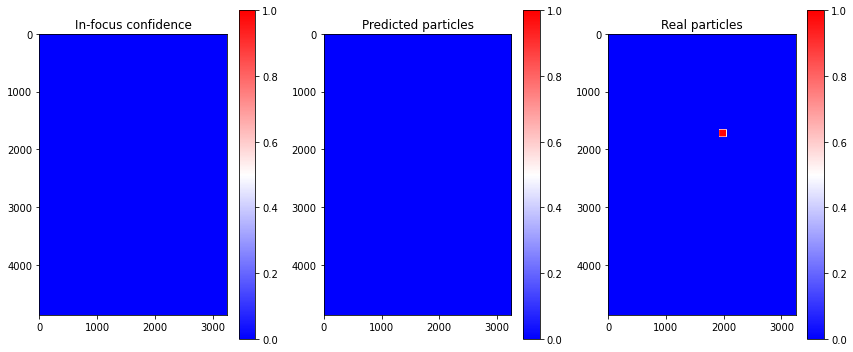

Plane 18 at z: 0.016663999999999998 balanced_acc: 0.9732 balanced_holo_acc: 0.9626:   2%|▏         | 24/1000 [03:20<2:35:52,  9.58s/it]

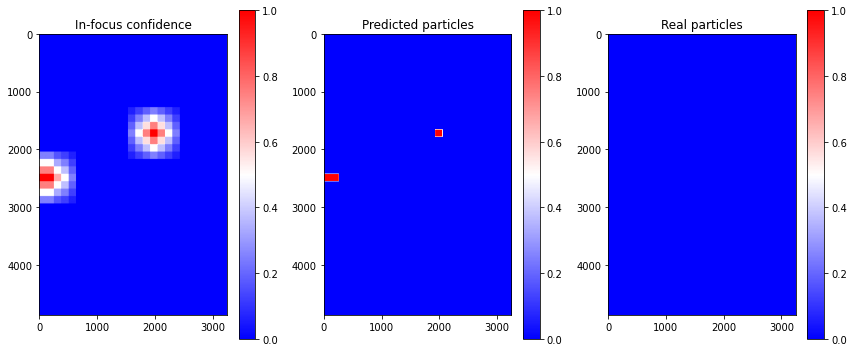

Plane 19 at z: 0.016808 balanced_acc: 0.9955 balanced_holo_acc: 0.9643:   2%|▎         | 25/1000 [03:31<2:40:15,  9.86s/it]            

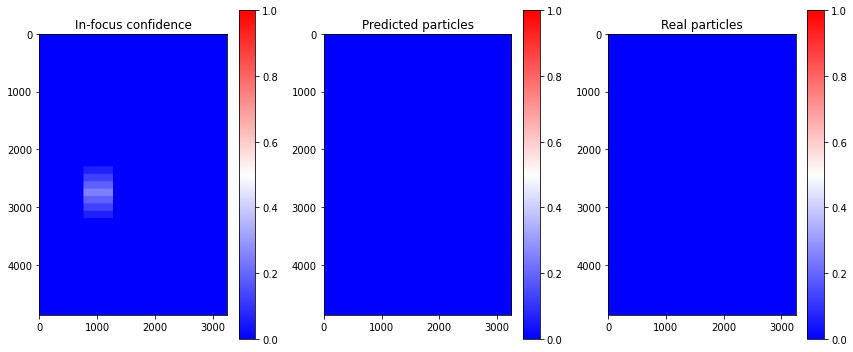

Plane 20 at z: 0.016952 balanced_acc: 0.9888 balanced_holo_acc: 0.9654:   3%|▎         | 26/1000 [03:41<2:44:33, 10.14s/it]

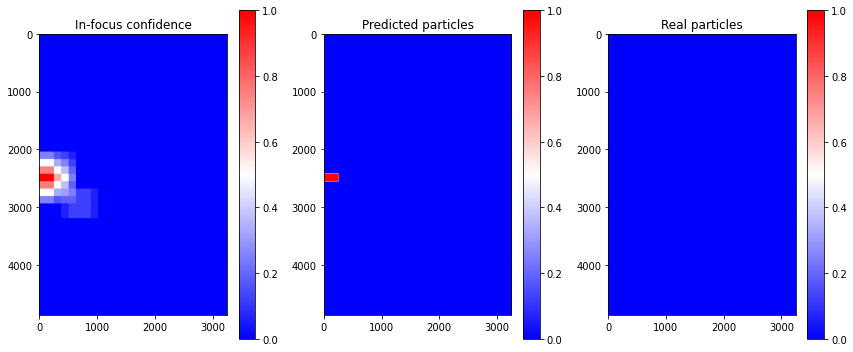

Plane 21 at z: 0.017096 balanced_acc: 1.0000 balanced_holo_acc: 0.9670:   3%|▎         | 28/1000 [03:52<2:03:51,  7.65s/it]

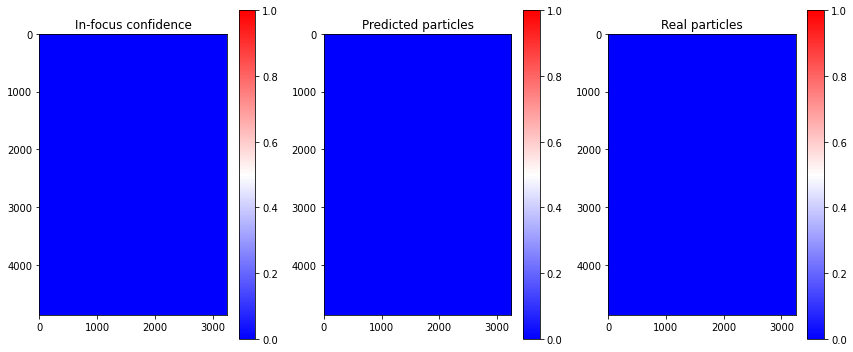

Plane 22 at z: 0.01724 balanced_acc: 0.9926 balanced_holo_acc: 0.9681:   3%|▎         | 29/1000 [04:03<2:20:22,  8.67s/it] 

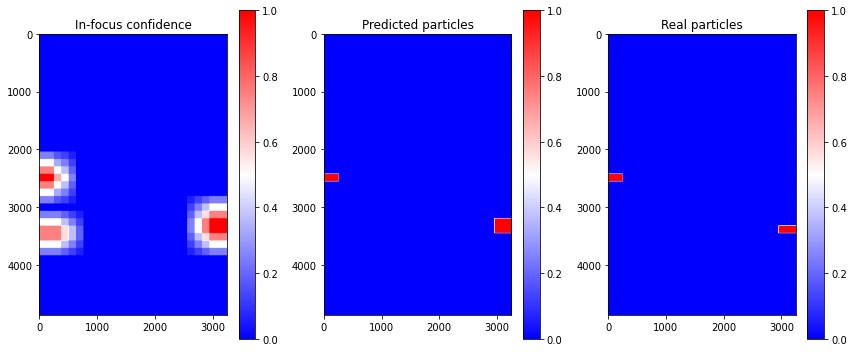

Plane 23 at z: 0.017384 balanced_acc: 0.9754 balanced_holo_acc: 0.9684:   3%|▎         | 30/1000 [04:14<2:30:19,  9.30s/it]

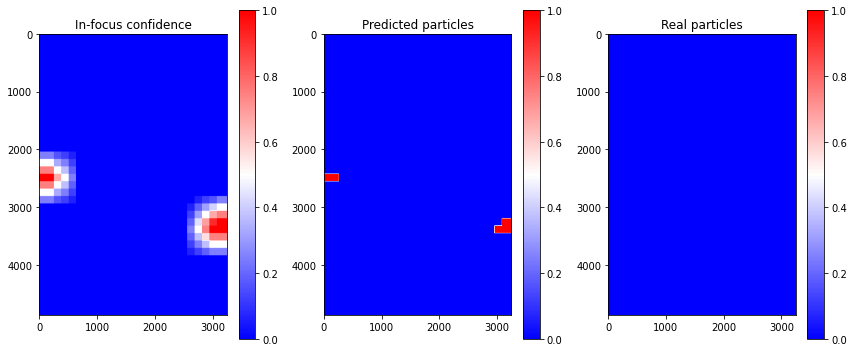

Plane 24 at z: 0.017528 balanced_acc: 0.9833 balanced_holo_acc: 0.9690:   3%|▎         | 31/1000 [04:25<2:36:59,  9.72s/it]

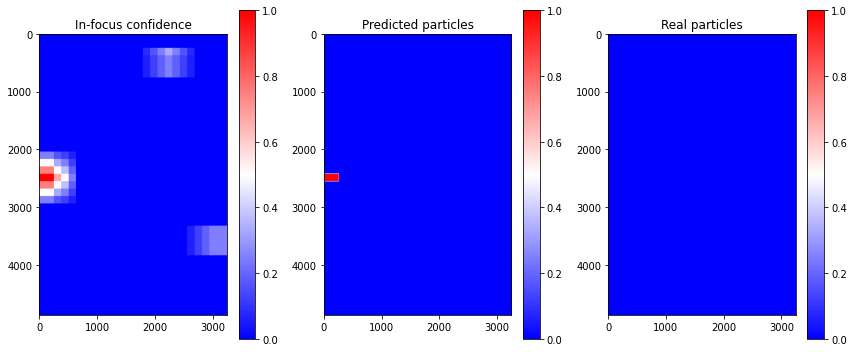

Plane 25 at z: 0.017672 balanced_acc: 1.0000 balanced_holo_acc: 0.9702:   3%|▎         | 32/1000 [04:35<2:41:49, 10.03s/it]

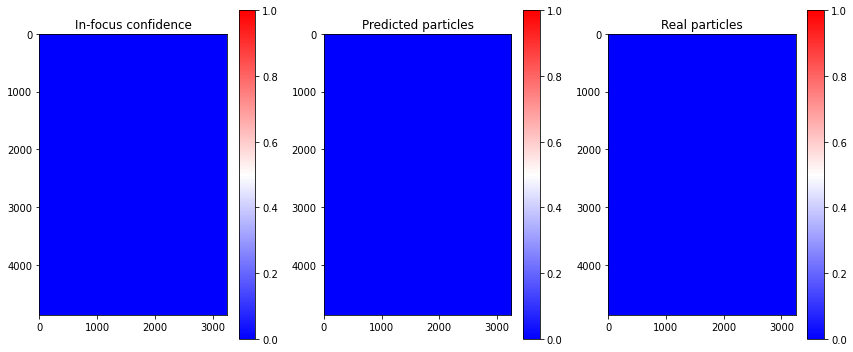

Plane 26 at z: 0.017816 balanced_acc: 0.9843 balanced_holo_acc: 0.9707:   3%|▎         | 33/1000 [04:47<2:47:22, 10.39s/it]

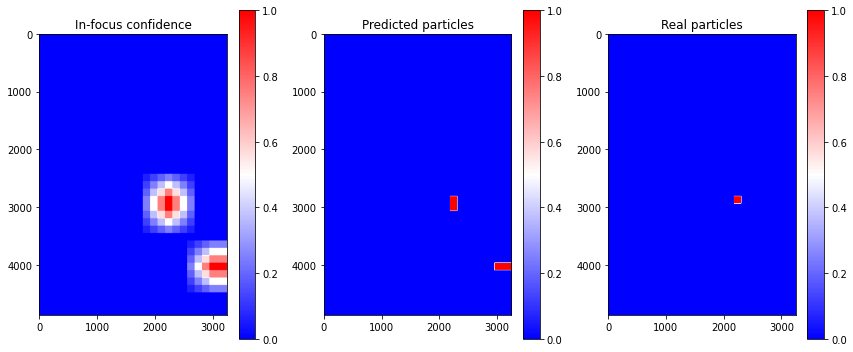

Plane 27 at z: 0.01796 balanced_acc: 0.9777 balanced_holo_acc: 0.9710:   3%|▎         | 34/1000 [04:57<2:48:16, 10.45s/it] 

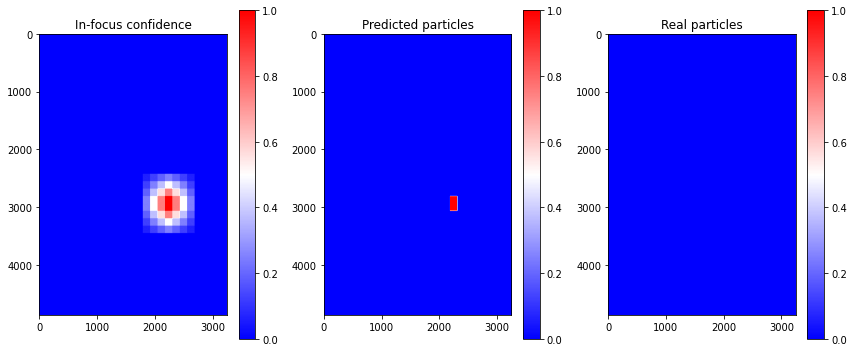

Plane 28 at z: 0.018104 balanced_acc: 1.0000 balanced_holo_acc: 0.9720:   4%|▎         | 36/1000 [05:08<2:05:08,  7.79s/it]

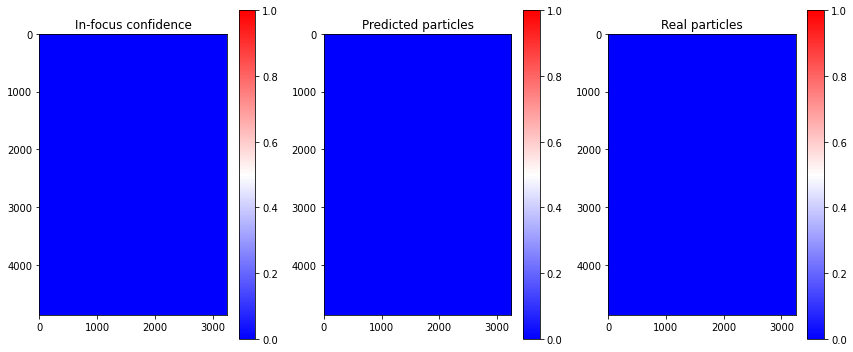

Plane 29 at z: 0.018248 balanced_acc: 0.9955 balanced_holo_acc: 0.9728:   4%|▎         | 37/1000 [05:19<2:18:58,  8.66s/it]

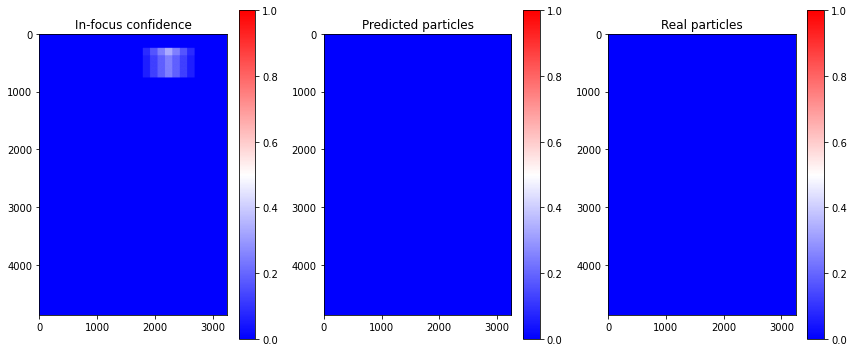

Plane 30 at z: 0.018392 balanced_acc: 0.9821 balanced_holo_acc: 0.9731:   4%|▍         | 38/1000 [05:29<2:27:50,  9.22s/it]

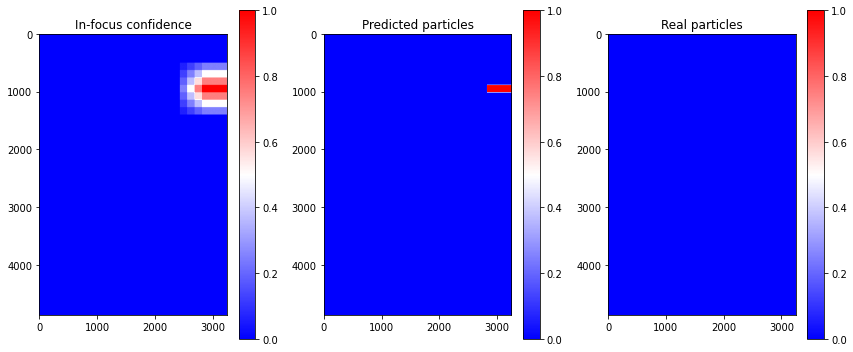

Plane 31 at z: 0.018536 balanced_acc: 0.9901 balanced_holo_acc: 0.9736:   4%|▍         | 39/1000 [05:40<2:35:30,  9.71s/it]

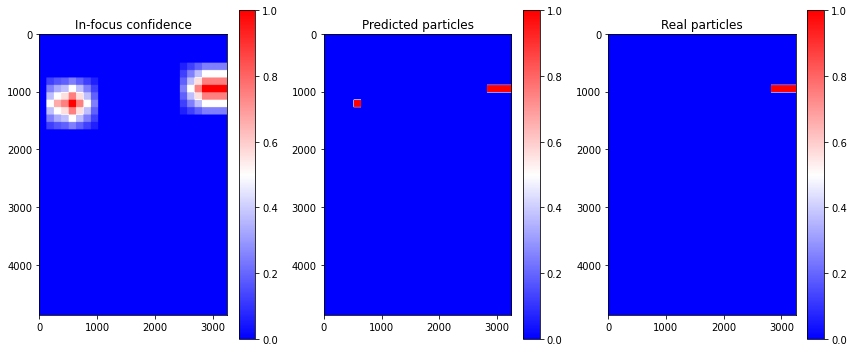

Plane 32 at z: 0.01868 balanced_acc: 1.0000 balanced_holo_acc: 0.9744:   4%|▍         | 40/1000 [05:51<2:40:25, 10.03s/it] 

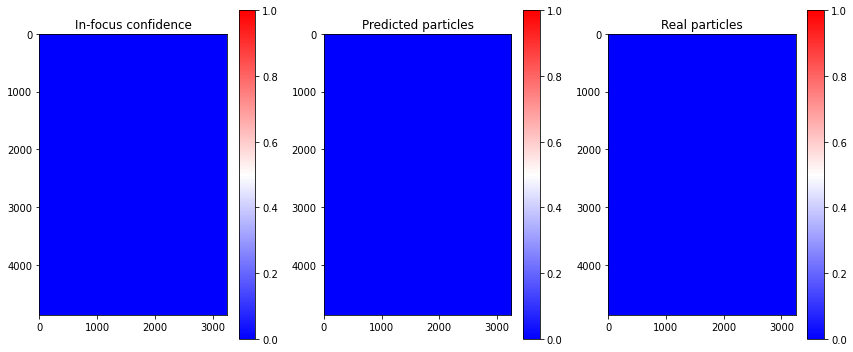

Plane 33 at z: 0.018824 balanced_acc: 0.9410 balanced_holo_acc: 0.9734:   4%|▍         | 41/1000 [06:01<2:42:33, 10.17s/it]

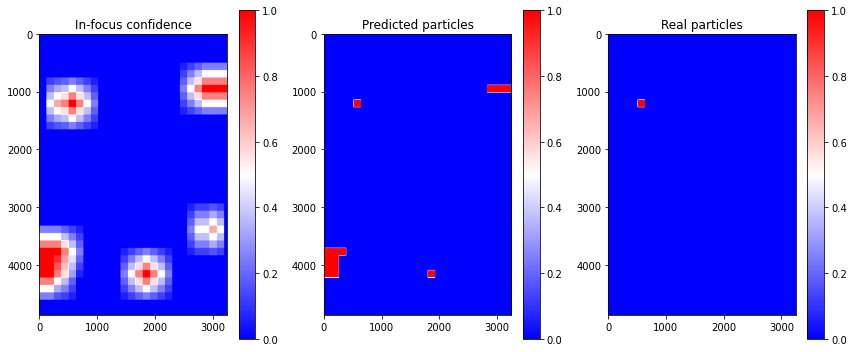

Plane 34 at z: 0.018968 balanced_acc: 0.9821 balanced_holo_acc: 0.9737:   4%|▍         | 42/1000 [06:12<2:45:25, 10.36s/it]

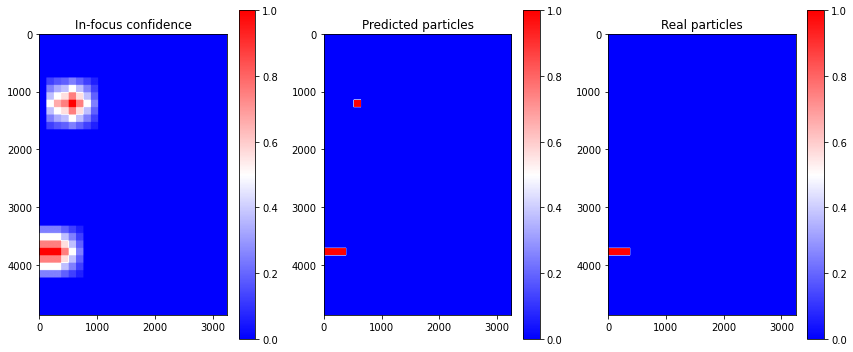

Plane 35 at z: 0.019112 balanced_acc: 0.9598 balanced_holo_acc: 0.9733:   4%|▍         | 43/1000 [06:23<2:46:58, 10.47s/it]

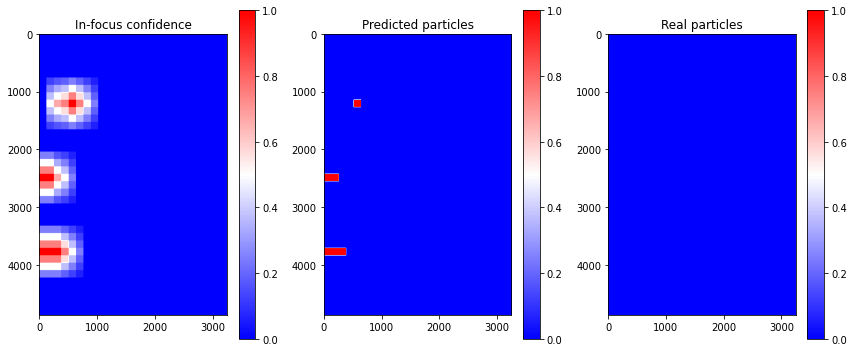

Plane 36 at z: 0.019256 balanced_acc: 1.0000 balanced_holo_acc: 0.9740:   4%|▍         | 45/1000 [06:33<2:02:19,  7.69s/it]

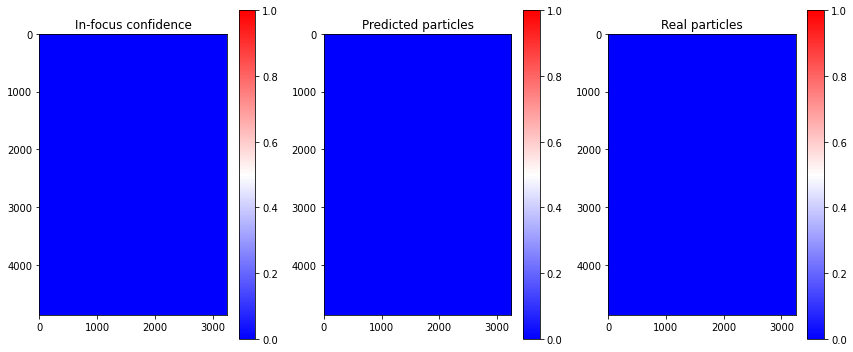

Plane 37 at z: 0.0194 balanced_acc: 0.9397 balanced_holo_acc: 0.9731:   5%|▍         | 46/1000 [06:44<2:14:51,  8.48s/it]  

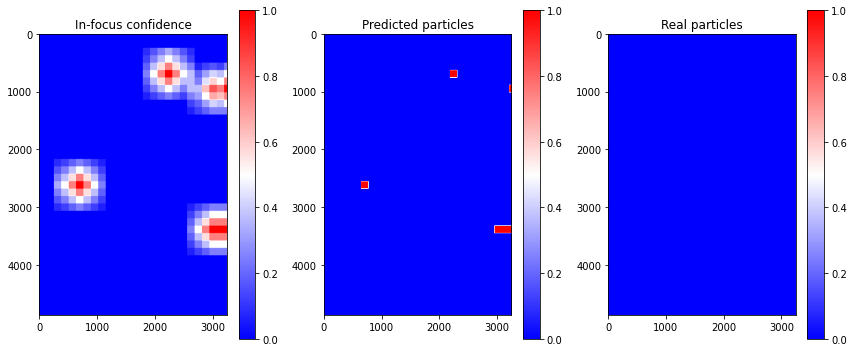

Plane 38 at z: 0.019544 balanced_acc: 1.0000 balanced_holo_acc: 0.9738:   5%|▍         | 47/1000 [06:54<2:24:15,  9.08s/it]

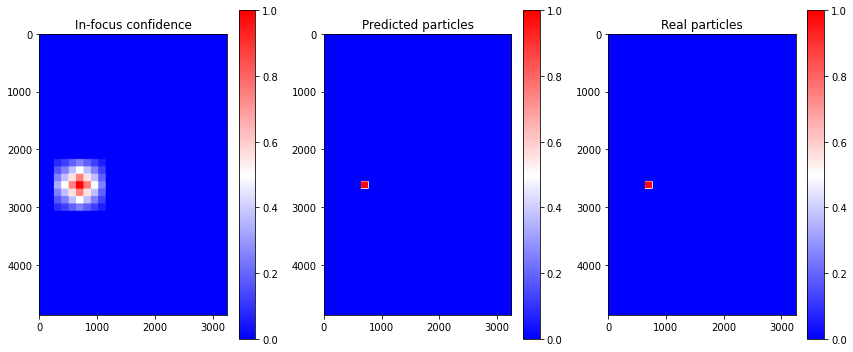

Plane 39 at z: 0.019688 balanced_acc: 0.9621 balanced_holo_acc: 0.9735:   5%|▍         | 48/1000 [07:04<2:29:33,  9.43s/it]

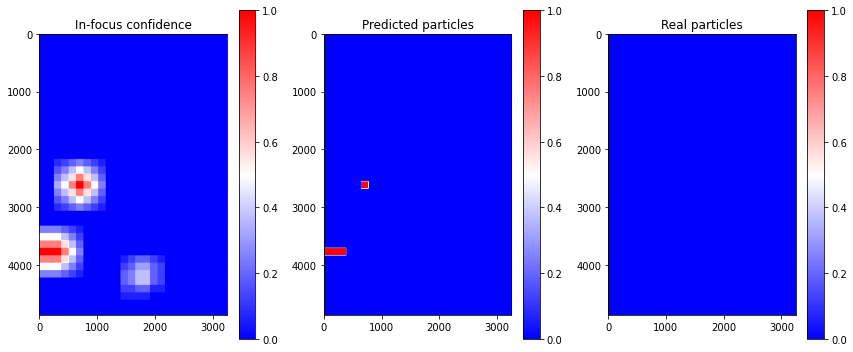

Plane 40 at z: 0.019832 balanced_acc: 0.9821 balanced_holo_acc: 0.9737:   5%|▍         | 49/1000 [07:15<2:33:25,  9.68s/it]

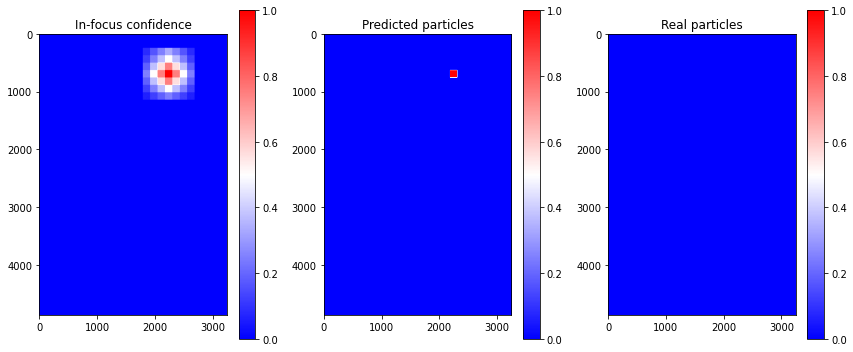

Plane 41 at z: 0.019976 balanced_acc: 0.9732 balanced_holo_acc: 0.9737:   5%|▌         | 50/1000 [07:25<2:35:12,  9.80s/it]

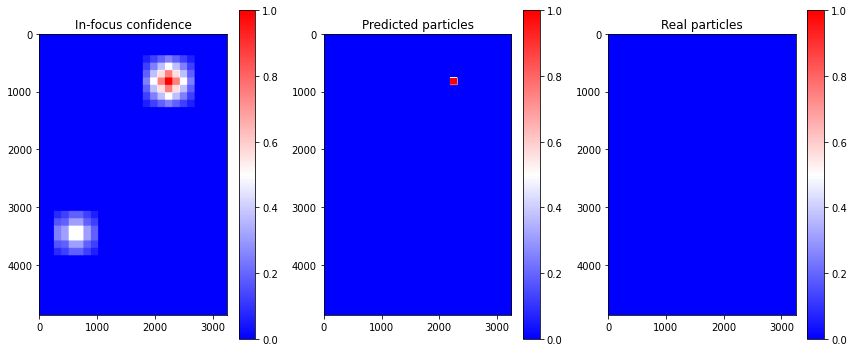

Plane 42 at z: 0.02012 balanced_acc: 0.9821 balanced_holo_acc: 0.9739:   5%|▌         | 51/1000 [07:35<2:38:28, 10.02s/it] 

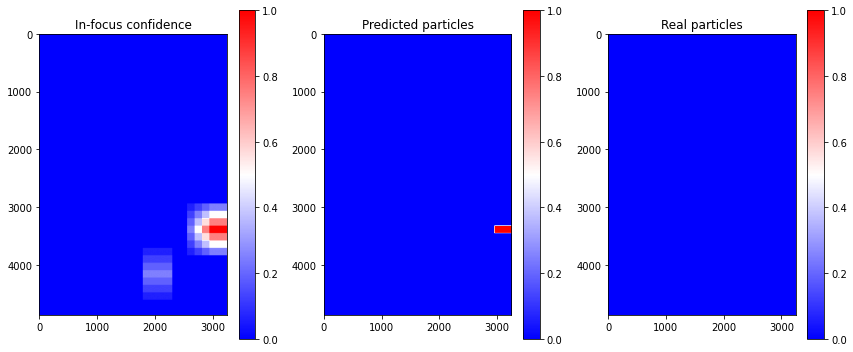

Plane 43 at z: 0.020264 balanced_acc: 0.8571 balanced_holo_acc: 0.9712:   5%|▌         | 52/1000 [07:47<2:46:27, 10.54s/it]

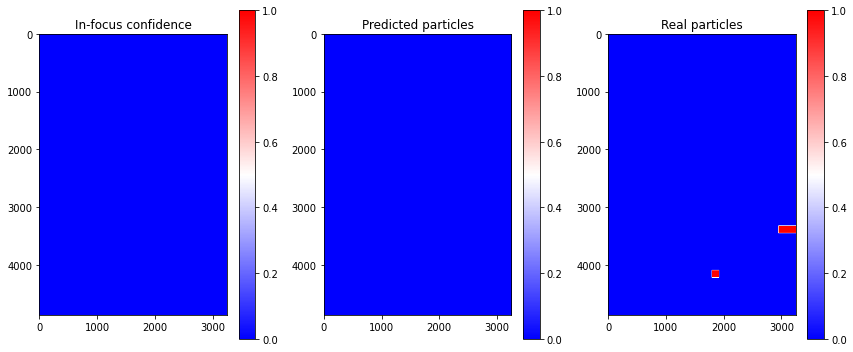

Plane 44 at z: 0.020408 balanced_acc: 0.9768 balanced_holo_acc: 0.9714:   5%|▌         | 53/1000 [08:00<2:57:37, 11.25s/it]

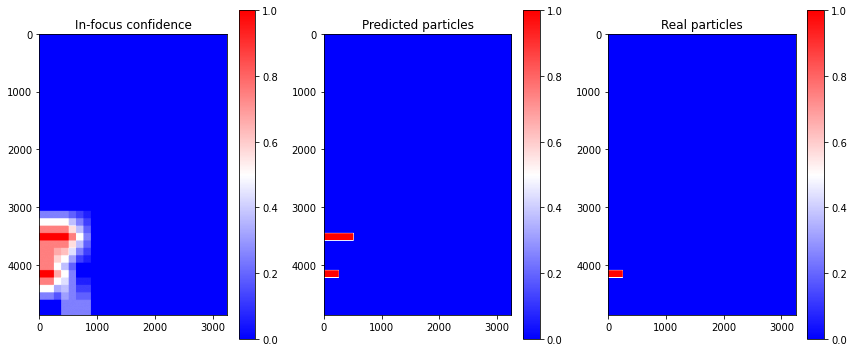

Plane 45 at z: 0.020551999999999997 balanced_acc: 0.9506 balanced_holo_acc: 0.9709:   6%|▌         | 55/1000 [08:13<2:19:18,  8.84s/it]

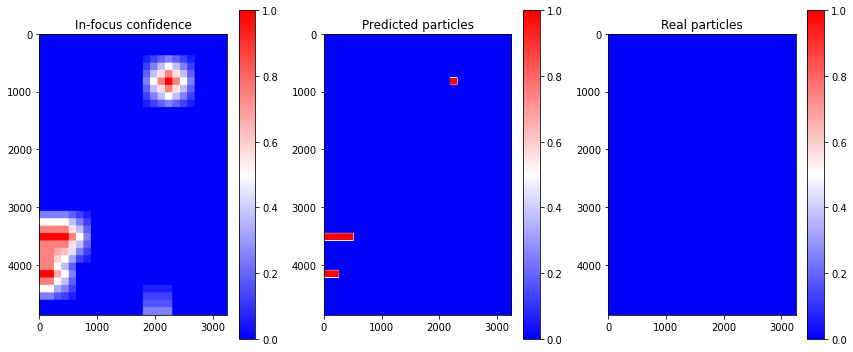

Plane 46 at z: 0.020696 balanced_acc: 0.9553 balanced_holo_acc: 0.9706:   6%|▌         | 56/1000 [08:24<2:30:16,  9.55s/it]            

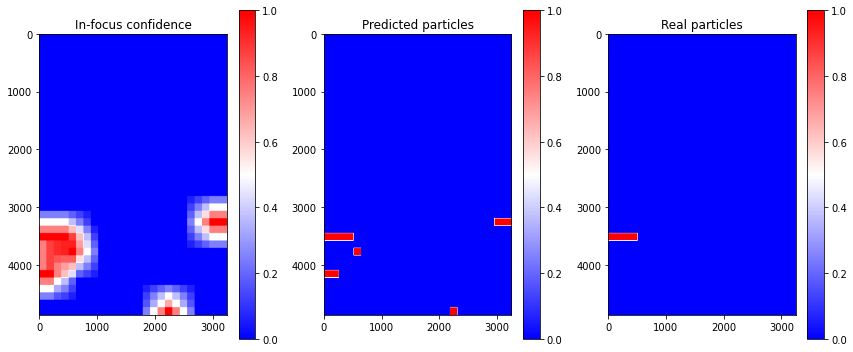

Plane 47 at z: 0.020839999999999997 balanced_acc: 1.0000 balanced_holo_acc: 0.9712:   6%|▌         | 57/1000 [08:35<2:36:21,  9.95s/it]

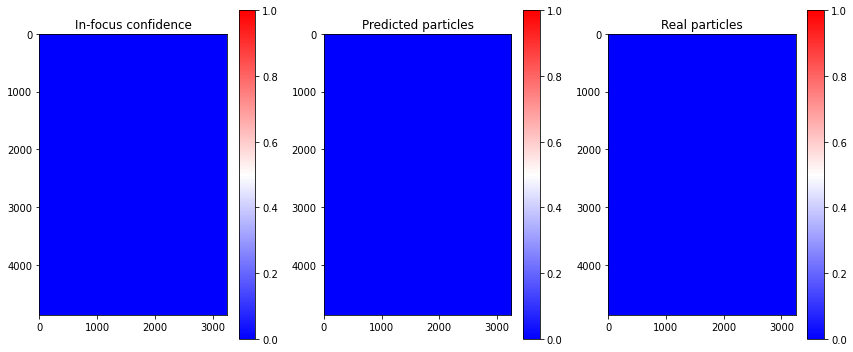

Plane 48 at z: 0.020984 balanced_acc: 0.8760 balanced_holo_acc: 0.9692:   6%|▌         | 58/1000 [08:45<2:37:48, 10.05s/it]            

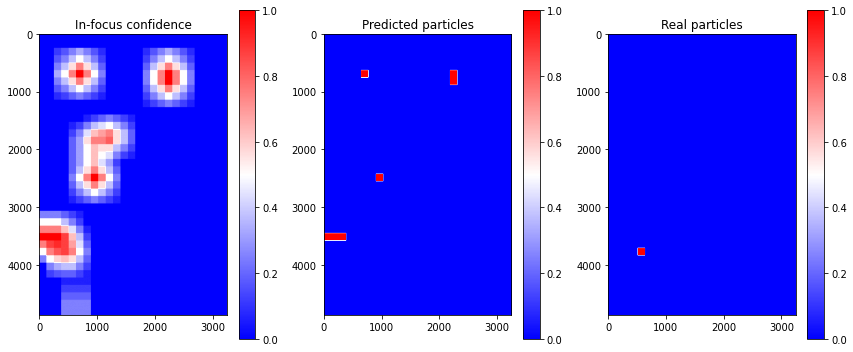

Plane 49 at z: 0.021127999999999997 balanced_acc: 0.9798 balanced_holo_acc: 0.9695:   6%|▌         | 59/1000 [08:56<2:41:21, 10.29s/it]

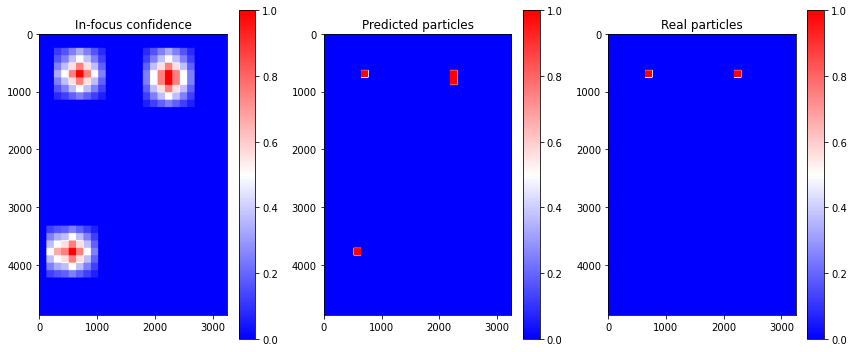

Plane 50 at z: 0.021272 balanced_acc: 0.9174 balanced_holo_acc: 0.9684:   6%|▌         | 60/1000 [09:07<2:42:25, 10.37s/it]            

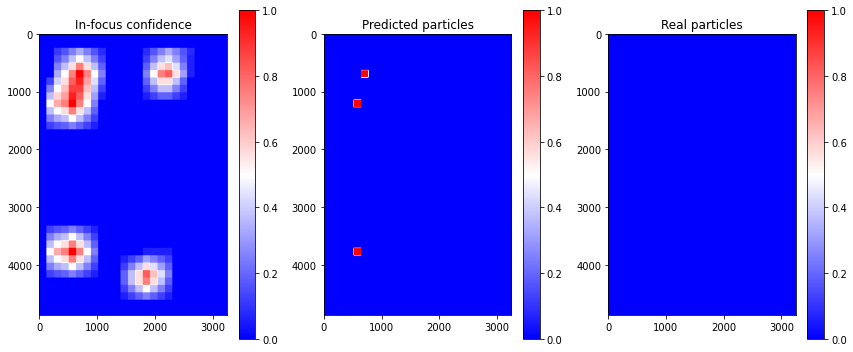

Plane 51 at z: 0.021415999999999998 balanced_acc: 1.0000 balanced_holo_acc: 0.9690:   6%|▌         | 61/1000 [09:17<2:42:50, 10.40s/it]

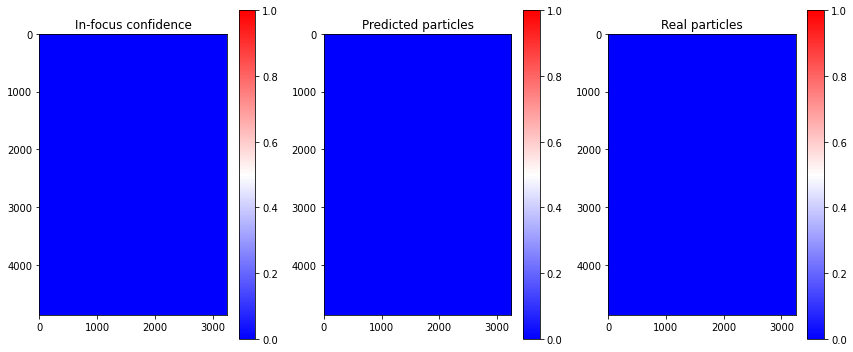

Plane 52 at z: 0.02156 balanced_acc: 0.9732 balanced_holo_acc: 0.9691:   6%|▌         | 62/1000 [09:27<2:41:29, 10.33s/it]             

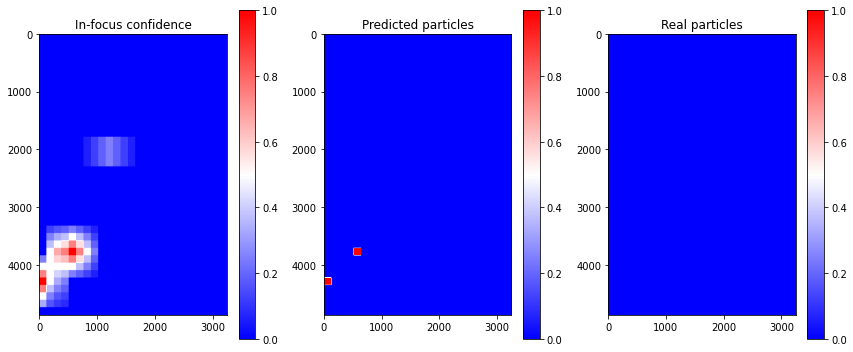

Plane 53 at z: 0.021703999999999998 balanced_acc: 0.9978 balanced_holo_acc: 0.9697:   6%|▋         | 63/1000 [09:38<2:41:40, 10.35s/it]

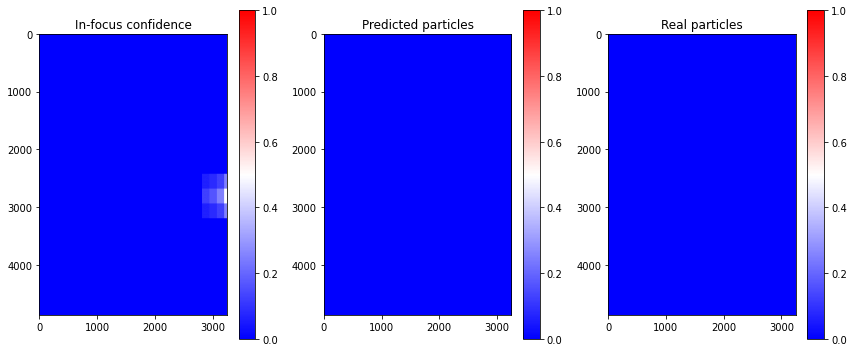

Plane 54 at z: 0.021848 balanced_acc: 0.9788 balanced_holo_acc: 0.9698:   6%|▋         | 64/1000 [09:48<2:41:46, 10.37s/it]            

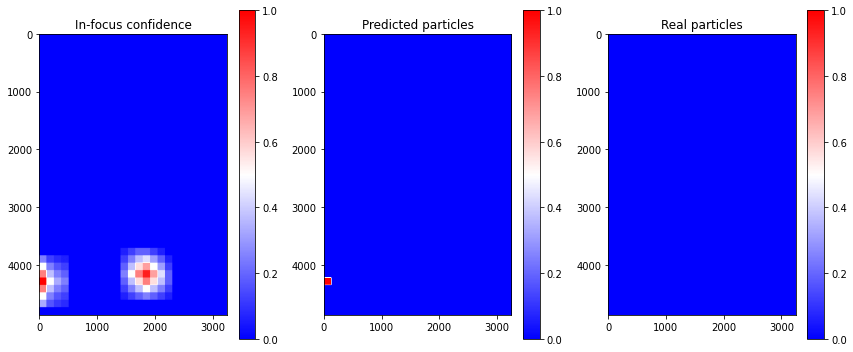

Plane 55 at z: 0.021991999999999998 balanced_acc: 0.8571 balanced_holo_acc: 0.9678:   7%|▋         | 66/1000 [10:00<2:02:40,  7.88s/it]

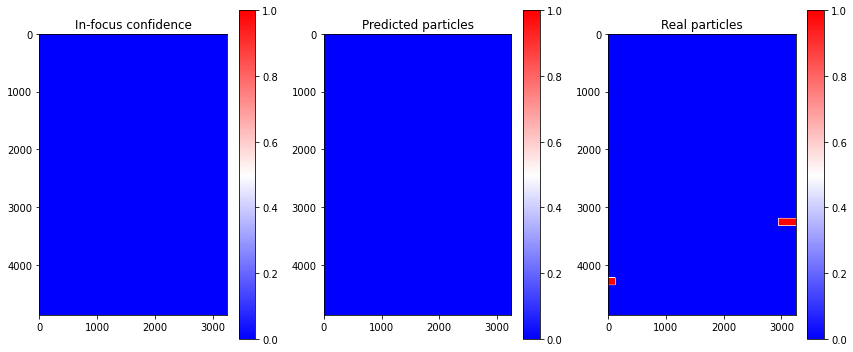

Plane 56 at z: 0.022136 balanced_acc: 0.9743 balanced_holo_acc: 0.9679:   7%|▋         | 67/1000 [10:10<2:15:01,  8.68s/it]            

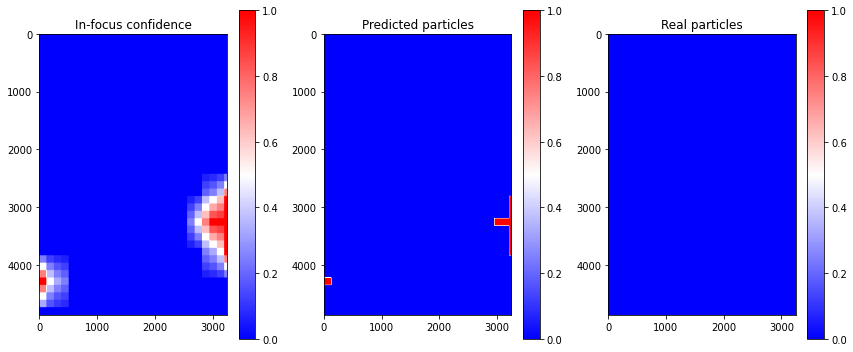

Plane 57 at z: 0.022279999999999998 balanced_acc: 0.9665 balanced_holo_acc: 0.9679:   7%|▋         | 68/1000 [10:21<2:23:39,  9.25s/it]

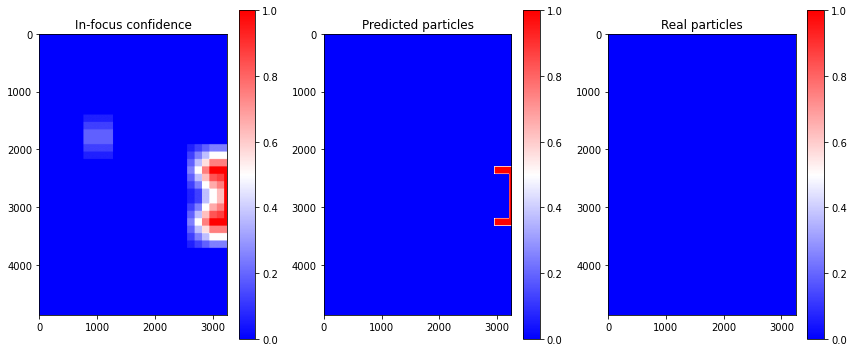

Plane 58 at z: 0.022424 balanced_acc: 0.9286 balanced_holo_acc: 0.9672:   7%|▋         | 69/1000 [10:31<2:30:47,  9.72s/it]            

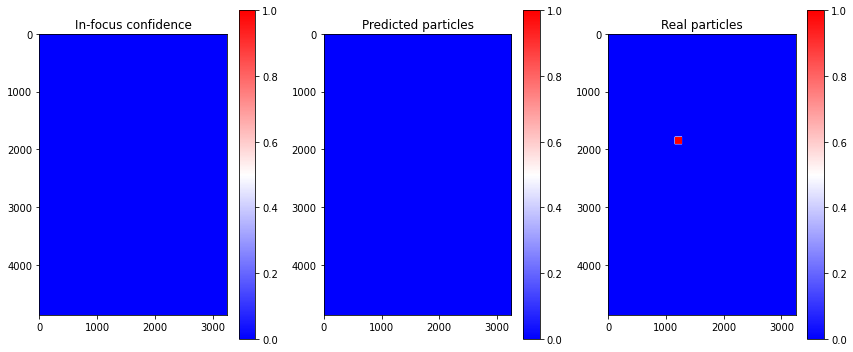

Plane 59 at z: 0.022567999999999998 balanced_acc: 0.9777 balanced_holo_acc: 0.9674:   7%|▋         | 70/1000 [10:42<2:33:52,  9.93s/it]

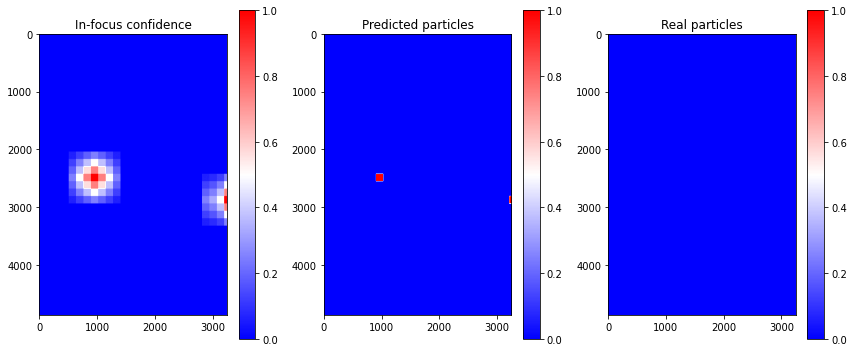

Plane 60 at z: 0.022712 balanced_acc: 1.0000 balanced_holo_acc: 0.9679:   7%|▋         | 71/1000 [10:52<2:36:03, 10.08s/it]            

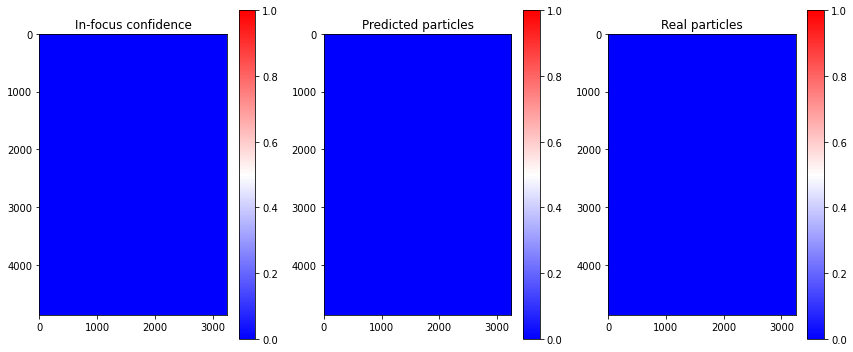

Plane 61 at z: 0.022855999999999998 balanced_acc: 0.8850 balanced_holo_acc: 0.9666:   7%|▋         | 72/1000 [11:03<2:38:26, 10.24s/it]

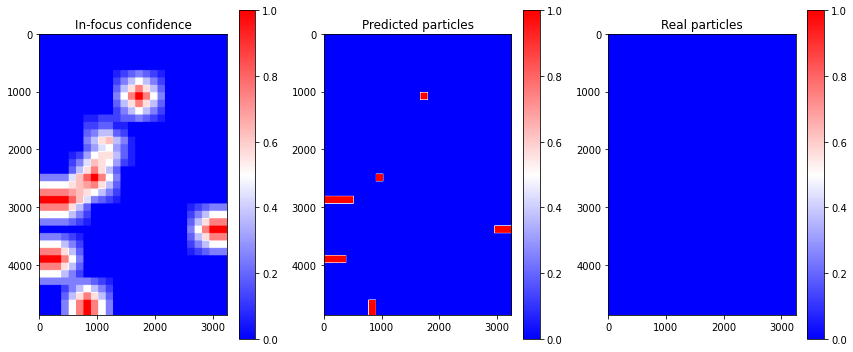

Plane 62 at z: 0.023 balanced_acc: 0.8571 balanced_holo_acc: 0.9649:   7%|▋         | 73/1000 [11:14<2:39:50, 10.35s/it]               

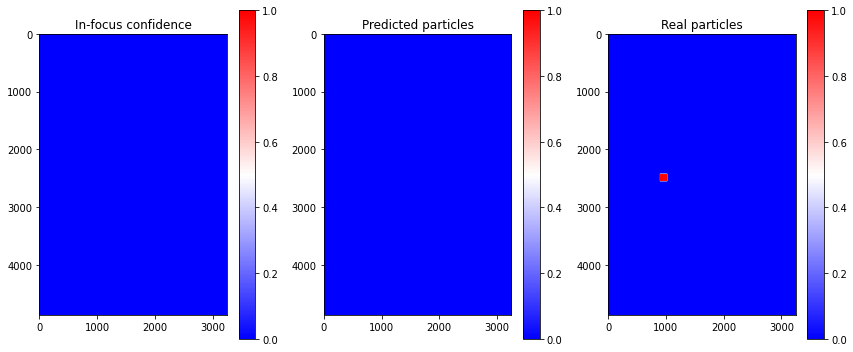

Plane 63 at z: 0.023143999999999998 balanced_acc: 0.9558 balanced_holo_acc: 0.9647:   7%|▋         | 74/1000 [11:24<2:41:48, 10.48s/it]

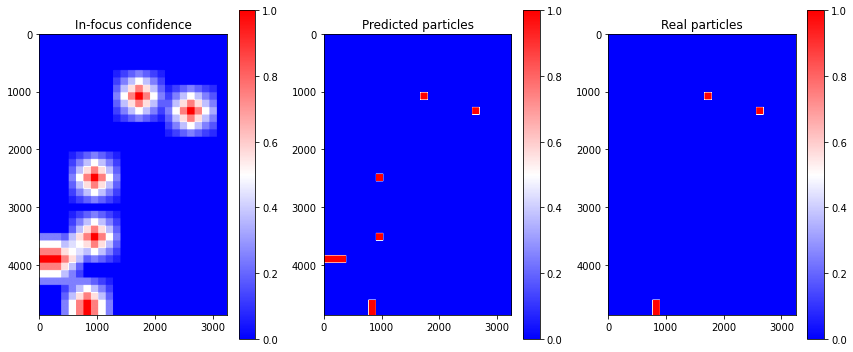

Plane 64 at z: 0.023288 balanced_acc: 0.9730 balanced_holo_acc: 0.9648:   8%|▊         | 75/1000 [11:35<2:42:32, 10.54s/it]            

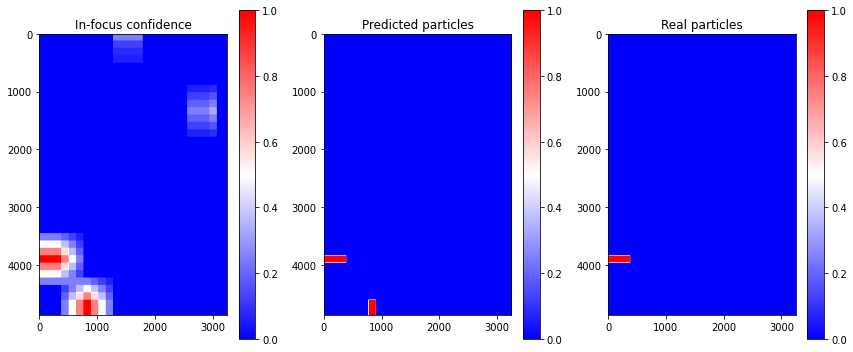

Plane 65 at z: 0.023431999999999998 balanced_acc: 0.7655 balanced_holo_acc: 0.9618:   8%|▊         | 76/1000 [11:46<2:44:03, 10.65s/it]

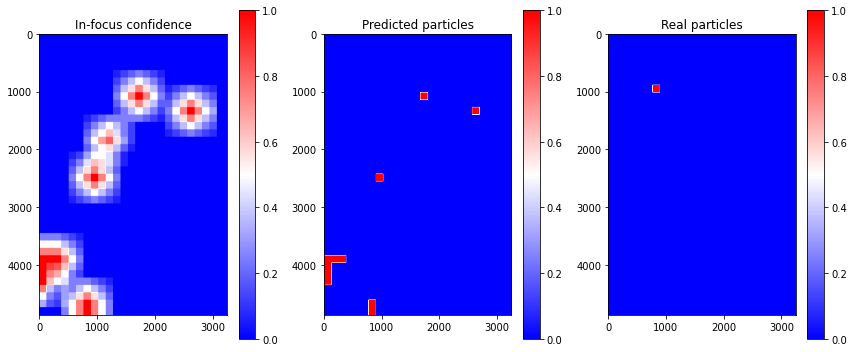

Plane 66 at z: 0.023576 balanced_acc: 1.0000 balanced_holo_acc: 0.9624:   8%|▊         | 78/1000 [11:56<1:59:49,  7.80s/it]            

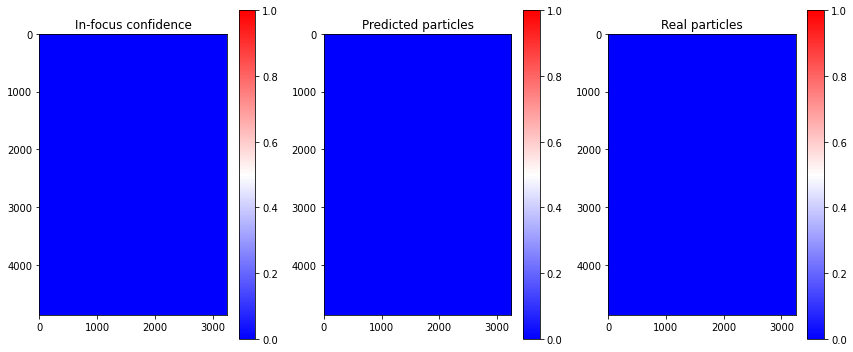

Plane 67 at z: 0.023719999999999998 balanced_acc: 0.9618 balanced_holo_acc: 0.9624:   7%|▋         | 67/1000 [12:09<2:49:13, 10.88s/it]


KeyboardInterrupt: 

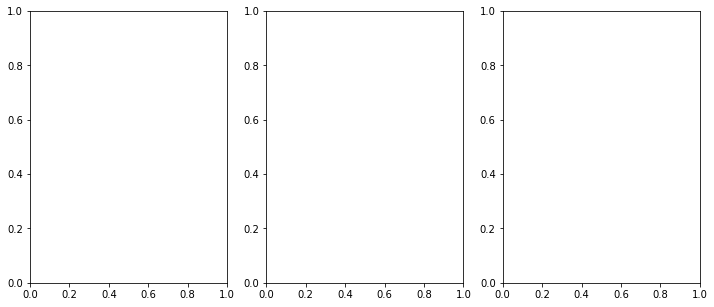

In [17]:
inference_batch_size = 128
#results_dict = {}

prob_results = {}
label_results = {}
truth_results = {}
accuracy = []

model.eval()
with torch.no_grad():
    
    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list), 
        leave=True
    )
    
    for jidx, (sub_images, image_index_lst, image_coords, image_z, im_pi, unet_labels, in_focus_labels) in jiter:

        def data_gen():
            for i in range(0, len(sub_images), inference_batch_size):
                yield (
                    sub_images[i:i+inference_batch_size],
                    image_index_lst[i:i+inference_batch_size],
                    image_coords[i:i+inference_batch_size],
                    image_z[i:i+inference_batch_size],
                    in_focus_labels[i:i+inference_batch_size]
                )

        recon_ims = []
        results_dict = {}
        block_accuracy = []
        for p, (sub_image, index, coords, z, truth_labels) in enumerate(data_gen()):
            tile_coordinates = np.hstack([coords, np.expand_dims(z, 1)])
            sub_image = torch.cat([torch.from_numpy(x).float().unsqueeze(0) for x in sub_image])
            sub_image = sub_image.to(device)
            image = torch.abs(sub_image).unsqueeze(1)
            phase = torch.angle(sub_image).unsqueeze(1)
            stacked_image = torch.cat([image, phase], 1)

            pred_logits = model(stacked_image)
            pred_probs, pred_labels = torch.max(pred_logits, 1)
            pred_probs = pred_probs.exp()
            
            acc = sklearn.metrics.balanced_accuracy_score(
                truth_labels,
                pred_labels.cpu().numpy()
            )
            #acc = np.mean([x == y for x,y in zip(list(pred_labels.cpu().numpy()), truth_labels)])
            accuracy.append(acc)
            block_accuracy.append(acc)
            
            for coor, key, prob, pred_label, truth_label in zip(tile_coordinates, index, pred_probs, pred_labels, truth_labels):
                results_dict[tuple(list(key))] = [prob.item(), pred_label.item(), truth_label] + list(coor)
                
        # update tqdm
        to_print = "Plane {} at z: {} balanced_acc: {:.4f} balanced_holo_acc: {:.4f}".format(jidx, z[0], np.mean(block_accuracy), np.mean(accuracy))
        jiter.set_description(to_print)
        jiter.update()
                
        # Make a plot
        z_indices = sorted(list(set([x[2] for x in results_dict.keys()])))
        for z_idx in z_indices:

            truths = np.zeros(test_image.shape)
            labels = np.zeros(test_image.shape)
            probs = np.zeros(test_image.shape)
            counter = np.zeros(test_image.shape)

            for row_idx in range(labels.shape[0] // step_size):

                if row_idx*step_size+tile_size > labels.shape[0]:
                    row_slice = slice(row_idx*step_size, row_idx*step_size+labels.shape[0]) #slice(-tile_size,None)
                    row_break = True
                else:
                    row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
                    row_break = False

                for col_idx in range(labels.shape[1]//step_size):

                    if col_idx*step_size+tile_size > labels.shape[1]:
                        col_slice = slice(col_idx*step_size, labels.shape[1]) #slice(-tile_size, None)
                        col_break = True
                    else:
                        col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
                        col_break = False

                    counter[row_slice, col_slice] += 1
                    truths[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][2]
                    labels[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][1]
                    probs[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][0]
                    
                    if col_break:
                        break

                if row_break:
                    break

            truths /= counter
            labels /= counter
            probs /= counter

            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            
            probs = [l * (1-p) + l * p for l,p in zip(labels, probs)]
            
            with open(f"images/truth_labels_{z_idx}.pkl", 'wb') as f:
                pickle.dump(truths, f)
            with open(f"images/pred_labels_{z_idx}.pkl", 'wb') as f:
                pickle.dump(labels, f)
            with open(f"images/pred_probs_{z_idx}.pkl", 'wb') as f:
                pickle.dump(probs, f)

            ###
            
            Cmap = 'bwr'
            
            p1 = ax0.imshow(probs, vmin = 0,  vmax = 1, cmap = Cmap)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            labels = labels == 1.0
            p2 = ax1.imshow(labels, vmin = 0, vmax = 1, cmap = Cmap)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            truths = truths == 1.0
            p3 = ax2.imshow(truths, vmin = 0, vmax = 1, cmap = Cmap)
            ax2.set_title("Real particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.savefig(f"images/plane_{jidx}.png")
            plt.show()
            
            prob_results[z_idx] = probs
            label_results[z_idx] = labels
            truth_results[z_idx] = truths

In [ ]:
#average_prob = np.vstack([np.expand_dims(x, 0) for x in prob_results.values()])
#average_label = np.vstack([np.expand_dims(x, 0) for x in label_results.values()])
#in_focus_prob = [l * (1-p) + l * p for l,p in zip(label_results.values(), prob_results.values())]
#in_focus_prob = np.vstack([np.expand_dims(x, 0) for x in in_focus_prob])

In [ ]:
#plt.imshow(np.sum(in_focus_prob, 0))

In [ ]:
#plt.imshow(test_image.values)

In [ ]:
# z_indices = sorted(list(set([x[2] for x in results_dict.keys()])))

# for z_idx in z_indices:
    
#     labels = np.zeros(test_image.shape)
#     probs = np.zeros(test_image.shape)
#     counter = np.zeros(test_image.shape)
    
#     for row_idx in range(labels.shape[0] // step_size):

#         if row_idx*step_size+tile_size > labels.shape[0]:
#             row_slice = slice(row_idx*step_size, row_idx*step_size+labels.shape[0]) #slice(-tile_size,None)
#             row_break = True
#         else:
#             row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
#             row_break = False

#         for col_idx in range(labels.shape[1]//step_size):

#             if col_idx*step_size+tile_size > labels.shape[1]:
#                 col_slice = slice(col_idx*step_size, labels.shape[1]) #slice(-tile_size, None)
#                 col_break = True
#             else:
#                 col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
#                 col_break = False

#             counter[row_slice, col_slice] += 1
#             labels[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][1]
#             probs[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][0]

#             if col_break:
#                 break

#         if row_break:
#             break

#     labels /= counter
#     probs /= counter
    
#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

#     p1 = ax0.imshow(probs, vmin = 0,  vmax = 1)
#     ax0.set_title("Predicted confidence")
#     fig.colorbar(p1, ax=ax0)

#     p2 = ax1.imshow(labels, vmin = 0, vmax = 1)
#     ax1.set_title("Predicted label")
#     fig.colorbar(p2, ax=ax1)

#     p3 = ax2.imshow(counter, vmin = 0, vmax = np.amax(counter))
#     ax2.set_title("Predicted counts")
#     fig.colorbar(p3, ax=ax2)

#     plt.tight_layout()
#     plt.show()

In [ ]:
# xs = [x[1][2] for x in results_dict.items()]
# ys = [x[1][3] for x in results_dict.items()]
#plt.scatter(xs, ys)

In [ ]:
# # parallelize the propagation step

# import multiprocessing as mp

# def worker(shared_queue = None, image = None, batch_size = 32, z_lst = None):
#     with torch.no_grad():
#         gen = get_next_z_planes(image, z_lst)
#         for (sub_images, image_index_lst, image_coords, image_z) in gen:
#             # use a generator to create batches
#             def data_gen():
#                 for i in range(0, len(sub_images), batch_size):
#                     yield (
#                         sub_images[i:i+batch_size],
#                         image_index_lst[i:i+batch_size],
#                         image_coords[i:i+batch_size],
#                         image_z[i:i+batch_size]
#                     )
#             for (sub_image, index, coords, z) in data_gen():
#                 # prep the input
#                 tile_coordinates = np.hstack([coords, np.expand_dims(z, 1)])
#                 image = np.expand_dims(np.abs(sub_image), 1)
#                 phase = np.expand_dims(np.angle(sub_image), 1)
#                 stacked_image = np.concatenate([image, phase], 1)
#                 # put onto a queue
#                 print("Putting stuff on the queue")
#                 shared_queue.put((stacked_image, index, tile_coordinates))
#     shared_queue.put("done")

In [ ]:
# m = mp.Manager()
# q = m.Queue()
  
# inference_batch_size = 32
# pool = mp.Pool(1, worker, (q, test_image, inference_batch_size, [z_lst[0]],))

# # with mp.Pool(2) as p:
# #     test_image = h_ds['image'].isel(hologram_number=h_idx)
# #     work = partial(q, worker, test_image, inference_batch_size)
# #     for result in p.imap(work, z_lst[0:2]):
# #         results.append(result)

# pool.close()
# pool.join_thread()

In [ ]:
#list(results_dict.keys())

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
total_params